import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import RAdam
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import torch.nn.utils as nn_utils
from torch.utils.data import DataLoader, TensorDataset, random_split
from scipy.optimize import minimize

Reading the training dataset

In [91]:
training_df = pd.read_csv('training.csv')
del training_df['Unnamed: 0']

Model classes. Models: PINN_SM, ANN, Traditional_PINN

In [68]:
class PINN_SM(nn.Module):
    def __init__(self):
        super(PINN_SM, self).__init__()
        # attention network
        self.attention_net = nn.Sequential(
            nn.Linear(6, 90),
            nn.Tanh(),
            nn.Linear(90, 10),
            nn.Sigmoid(),
        )
        # psi network
        self.psi_net = nn.Sequential(
            nn.Linear(16, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 1)
        )
        # theta network
        self.theta_net = nn.Sequential(
            nn.Linear(1, 90),
            nn.Tanh(),
            nn.Linear(90, 1),
            nn.Sigmoid()
        )
        # K network
        self.K_net = nn.Sequential(
            nn.Linear(1, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 1)
        )

        # Initialize the weights to be positive using Xavier initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.psi_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

        for m in self.theta_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                m.weight.data.clamp_(min=0)

        for m in self.K_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                m.weight.data.clamp_(min=0)
        for m in self.attention_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                m.weight.data.clamp_(min=0)
    # forward pass of the network
    def forward(self, inputs):

        attention_weights = self.attention_net(inputs[:, 0:6])
        new_R = inputs[:, 6:] * attention_weights
        inputs = torch.cat([inputs[:, 0:6], new_R], dim=-1)

        psi = -torch.exp(self.psi_net(inputs))
        K = torch.exp(self.K_net(-torch.log(-psi)))
        theta = self.theta_net(-torch.log(-psi))

        return psi,K,theta
# function defined to keep the theta network and k network positive
def enforce_positive_weights(model):
    for m in model.theta_net.modules():
        if isinstance(m, nn.Linear):
            m.weight.data.abs_()
            m.bias.data.abs_()
    for m in model.K_net.modules():
        if isinstance(m, nn.Linear):
            m.weight.data.abs_()
            m.bias.data.abs_()
def loss_function(model, inputs, theta):

    inputs.requires_grad = True
    psi,K,theta_pred = model(inputs)

   # Compute gradients with respect to inputs
    psi_z = torch.autograd.grad(psi, inputs, grad_outputs=torch.ones_like(psi), create_graph=True)[0][:, 1].unsqueeze(1)
    psi_zz = torch.autograd.grad(psi_z, inputs, grad_outputs=torch.ones_like(psi_z), create_graph=True)[0][:, 1].unsqueeze(1)
    theta_t = torch.autograd.grad(theta_pred, inputs, grad_outputs=torch.ones_like(theta_pred), create_graph=True)[0][:, 0].unsqueeze(1)
    K_z = torch.autograd.grad(K, inputs, grad_outputs=torch.ones_like(K), create_graph=True)[0][:, 1].unsqueeze(1)

    # PDE residual for the Richards-Richards equation
    r = theta_t - K_z * psi_z - K * psi_zz - K_z

    # Loss components
    data_fitting_loss = torch.mean(((theta_pred - theta) ** 2))
    pde_residual_loss = torch.mean(r ** 2)

    # Compute gradients with respect to model parameters
    data_fitting_grad = torch.autograd.grad(data_fitting_loss, model.parameters(), create_graph=True,allow_unused=True)
    pde_residual_grad = torch.autograd.grad(pde_residual_loss, model.parameters(), create_graph=True,allow_unused=True)

    # Calculate maximum gradient of PDE residual component
    max_grad_pde_residual = max(g.abs().max() for g in pde_residual_grad if g is not None)

    # Calculate average gradient of data-fitting component
    avg_grad_data_fitting = torch.mean(torch.stack([g.abs().mean() for g in data_fitting_grad if g is not None]))

    # Compute the ratio
    gradient_ratio = max_grad_pde_residual / avg_grad_data_fitting

    if gradient_ratio>1:

      total_loss = data_fitting_loss + (1/gradient_ratio)*pde_residual_loss
      #print('PDE RESIDUAL ADJUSTMENT')

    else:

      total_loss = data_fitting_loss + pde_residual_loss

    return total_loss
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        # attention network
        self.attention_net = nn.Sequential(
            nn.Linear(6, 90),
            nn.Tanh(),
            nn.Linear(90, 10),
            nn.Sigmoid(),
        )
        # psi network
        self.psi_net = nn.Sequential(
            nn.Linear(16, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 1)
        )
        # theta network
        self.theta_net = nn.Sequential(
            nn.Linear(1, 90),
            nn.Tanh(),
            nn.Linear(90, 1),
            nn.Sigmoid()
        )
        # K network
        self.K_net = nn.Sequential(
            nn.Linear(1, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 1)
        )

        # Initialize the weights to be positive using Xavier initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.psi_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

        for m in self.theta_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                m.weight.data.clamp_(min=0)

        for m in self.K_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                m.weight.data.clamp_(min=0)
        for m in self.attention_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                m.weight.data.clamp_(min=0)
    # forward pass of the network
    def forward(self, inputs):

        attention_weights = self.attention_net(inputs[:, 0:6])
        new_R = inputs[:, 6:] * attention_weights
        inputs = torch.cat([inputs[:, 0:6], new_R], dim=-1)

        psi = -torch.exp(self.psi_net(inputs))
        K = torch.exp(self.K_net(-torch.log(-psi)))
        theta = self.theta_net(-torch.log(-psi))

        return psi,K,theta
# function defined to keep the theta network and k network positive
def enforce_positive_weights(model):
    for m in model.theta_net.modules():
        if isinstance(m, nn.Linear):
            m.weight.data.abs_()
            m.bias.data.abs_()
    for m in model.K_net.modules():
        if isinstance(m, nn.Linear):
            m.weight.data.abs_()
            m.bias.data.abs_()
def loss_function(model, inputs, theta):

    inputs.requires_grad = True
    psi,K,theta_pred = model(inputs)


    # Loss components
    data_fitting_loss = torch.mean(((theta_pred - theta) ** 2))
    total_loss = data_fitting_loss
    return total_loss

### Traditional PINN

class Traditional_PINN(nn.Module):
    def __init__(self):
        super(Traditional_PINN, self).__init__()

        self.psi_net = nn.Sequential(
            nn.Linear(2, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 1)
        )

        self.theta_net = nn.Sequential(
            nn.Linear(1, 90),
            nn.Tanh(),
            nn.Linear(90, 1),
            nn.Sigmoid()
        )

        self.K_net = nn.Sequential(
            nn.Linear(1, 90),
            nn.Tanh(),
            nn.Linear(90, 90),
            nn.Tanh(),
            nn.Linear(90, 1)
        )
        # Initialize the weights to be positive using Xavier initialization
        self._initialize_weights()

    def _initialize_weights(self):

        for m in self.psi_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

        for m in self.theta_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                m.weight.data.clamp_(min=0)

        for m in self.K_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
                m.weight.data.clamp_(min=0)

    def forward(self, inputs):

        psi = -torch.exp(self.psi_net(inputs[:,0:2]))
        K = torch.exp(self.K_net(-torch.log(-psi)))
        theta = self.theta_net(-torch.log(-psi))

        return psi,K,theta

def enforce_positive_weights(model):
    for m in model.theta_net.modules():
        if isinstance(m, nn.Linear):
            m.weight.data.abs_()
            m.bias.data.abs_()
    for m in model.K_net.modules():
        if isinstance(m, nn.Linear):
            m.weight.data.abs_()
            m.bias.data.abs_()
def loss_function(model, inputs, theta):

    inputs.requires_grad = True
    psi,K,theta_pred = model(inputs)

   # Compute gradients with respect to inputs
    psi_z = torch.autograd.grad(psi, inputs, grad_outputs=torch.ones_like(psi), create_graph=True)[0][:, 1].unsqueeze(1)
    psi_zz = torch.autograd.grad(psi_z, inputs, grad_outputs=torch.ones_like(psi_z), create_graph=True)[0][:, 1].unsqueeze(1)
    theta_t = torch.autograd.grad(theta_pred, inputs, grad_outputs=torch.ones_like(theta_pred), create_graph=True)[0][:, 0].unsqueeze(1)
    K_z = torch.autograd.grad(K, inputs, grad_outputs=torch.ones_like(K), create_graph=True)[0][:, 1].unsqueeze(1)

    # PDE residual for the Richards-Richards equation
    r = theta_t - K_z * psi_z - K * psi_zz - K_z

    # Loss components
    data_fitting_loss = torch.mean(((theta_pred - theta) ** 2))
    pde_residual_loss = torch.mean(r ** 2)

    # Compute gradients with respect to model parameters
    data_fitting_grad = torch.autograd.grad(data_fitting_loss, model.parameters(), create_graph=True,allow_unused=True)
    pde_residual_grad = torch.autograd.grad(pde_residual_loss, model.parameters(), create_graph=True,allow_unused=True)

    # Calculate maximum gradient of PDE residual component
    max_grad_pde_residual = max(g.abs().max() for g in pde_residual_grad if g is not None)

    # Calculate average gradient of data-fitting component
    avg_grad_data_fitting = torch.mean(torch.stack([g.abs().mean() for g in data_fitting_grad if g is not None]))

    # Compute the ratio
    gradient_ratio = max_grad_pde_residual / avg_grad_data_fitting

    if gradient_ratio>1:

      total_loss = data_fitting_loss + (1/gradient_ratio)*pde_residual_loss
      #print('PDE RESIDUAL ADJUSTMENT')

    else:

      total_loss = data_fitting_loss + pde_residual_loss

    return total_loss

Training function

In [69]:
def train(model, optimizer, dataloader, test_loader, epochs):
    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0
        for batch_idx, (inputs_batch, theta_batch) in enumerate(dataloader):
            inputs_batch.to(device)
            theta_batch.to(device)
            optimizer.zero_grad()
            loss = loss_function(model, inputs_batch, theta_batch)
            if torch.isnan(loss).any() or torch.isinf(loss).any():
                print(f'Warning: Loss is NaN or Inf at epoch {epoch}, batch {batch_idx}')
                continue
            loss.backward()
            nn_utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            enforce_positive_weights(model)
            total_loss += loss.item()
            num_batches += 1
        average_loss = total_loss / num_batches
        print(f'Epoch {epoch}, Average Training Loss: {average_loss}')
        test_loss = 0
        num_batches_test = 0
        for batch_idx, (inputs_batch, theta_batch) in enumerate(test_loader):
          inputs_batch.to(device)
          theta_batch.to(device)
          loss = loss_function(model, inputs_batch, theta_batch)
          test_loss += loss.item()
          num_batches_test += 1
        average_loss = test_loss / num_batches_test
        print(f'Epoch {epoch}, Average Test Loss: {average_loss}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Train - Test split

In [107]:
scaler = StandardScaler()
input_data = training_df.values[:,0:16]
scaler = scaler.fit(input_data)
scaled_data = scaler.transform(input_data) #with normalization!
inputs = torch.tensor(scaled_data, dtype=torch.float32).to(device)
theta = torch.tensor(training_df.iloc[:,16].values, dtype=torch.float32, requires_grad=True).unsqueeze(1).to(device)
dataset = TensorDataset(inputs, theta)
# Define the split ratio
train_size = int(0.6 * len(dataset))
test_size = len(dataset) - train_size
# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# Create DataLoaders for training and test sets
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

3 test periods for testing the soil moisture feedback to rainfall

In [117]:
date_ranges = [
    ('2024-03-16', '2024-03-18'),
    ('2024-04-07', '2024-04-10'),
    ('2024-04-30', '2024-05-02')
]
test1df = training_df[(training_df['time']>'2024-03-16')&(training_df['time']<'2024-03-19')]
test2df = training_df[(training_df['time']>'2024-04-07')&(training_df['time']<'2024-04-10')]
test3df = training_df[(training_df['time']>'2024-04-30')&(training_df['time']<'2024-05-02')]

input_test1 = torch.tensor(scaler.transform(test1df.values[:,0:16]),dtype=torch.float32).to(device)
input_test2 = torch.tensor(scaler.transform(test2df.values[:,0:16]),dtype=torch.float32).to(device)
input_test3 = torch.tensor(scaler.transform(test3df.values[:,0:16]),dtype=torch.float32).to(device)

theta_test1 = torch.tensor(test1df.iloc[:,16].values).to(device)
theta_test2 = torch.tensor(test2df.iloc[:,16].values).to(device)
theta_test3 = torch.tensor(test3df.iloc[:,16].values).to(device)

In [108]:
model = ANN()
optimizer = optim.Adam(model.parameters(), lr=0.003)
train(model, optimizer, train_loader, test_loader, epochs=60)

Epoch 0, Average Training Loss: 0.00991561525028594
Epoch 0, Average Test Loss: 0.0007915117047642442
Epoch 1, Average Training Loss: 0.0006501366971695626
Epoch 1, Average Test Loss: 0.0006377768533473665
Epoch 2, Average Training Loss: 0.0005851978115088334
Epoch 2, Average Test Loss: 0.0006585559742895632
Epoch 3, Average Training Loss: 0.0005026972984055509
Epoch 3, Average Test Loss: 0.0004930196585271253
Epoch 4, Average Training Loss: 0.0004549500520101212
Epoch 4, Average Test Loss: 0.0004324497666940178
Epoch 5, Average Training Loss: 0.00040458906777061975
Epoch 5, Average Test Loss: 0.0004920028408047405
Epoch 6, Average Training Loss: 0.00038370592863595283
Epoch 6, Average Test Loss: 0.00041454380433688954
Epoch 7, Average Training Loss: 0.0003544523853193051
Epoch 7, Average Test Loss: 0.0003231368017705708
Epoch 8, Average Training Loss: 0.00030477045528999895
Epoch 8, Average Test Loss: 0.00033700237690936774
Epoch 9, Average Training Loss: 0.00026037124079073584
Epoch 

KeyboardInterrupt: 

Testing

In [113]:
all_true_theta = []
all_predicted_theta = []

# Iterate over all batches
with torch.no_grad():
    for batch_id, (input, actual_theta) in enumerate(test_loader):
        # Compute true and predicted values
        true_theta = actual_theta.cpu().numpy()
        psi, K, theta_pred = model(input)
        prediction_theta = theta_pred.cpu().numpy()
        all_true_theta.append(true_theta)
        all_predicted_theta.append(prediction_theta)

#all_inputs = np.concatenate(all_inputs, axis=0)
all_true_theta = np.concatenate(all_true_theta, axis=0)
all_predicted_theta = np.concatenate(all_predicted_theta, axis=0)

In [114]:
MSE = ((all_predicted_theta - all_true_theta)**2).mean()
RMSE = MSE**(0.5)
print('MSE',MSE)
print('RMSE',RMSE)

MSE 0.00023150997
RMSE 0.015215451686867661


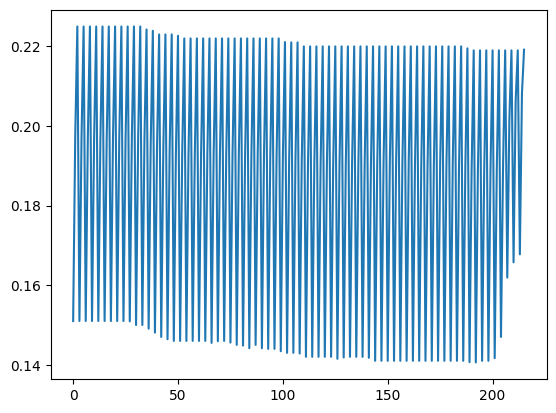

In [121]:
with torch.no_grad():

    true_theta_test1 = theta_test1.cpu().numpy()
    psi, K, theta_pred_test1 = model(input_test1)
    prediction_theta_test1 = theta_pred_test1.cpu().numpy()

plt.plot(true_theta_test1)